In [1]:
# Cellule 1: Import des bibliothèques nécessaires
import os
import numpy as np
import rasterio
from rasterio.plot import show
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# Cellule 2: Sélection et chargement du fichier TIF
# Remplacez ce chemin par votre propre fichier TIF
input_file = r"D:\UQTR\Hiver 2025\Télédétection\TP3\TR_clip.tif"

# Ouvrir le fichier pour l'analyse
src = rasterio.open(input_file)

# Informations sur l'image
print(f"Informations sur l'image {os.path.basename(input_file)}:")
print(f"Dimensions: {src.width} x {src.height} pixels")
print(f"Nombre total de bandes: {src.count}")
print(f"Type de données: {src.dtypes[0]}")
if src.crs:
    print(f"Système de coordonnées: {src.crs.to_string()}")

# Afficher la liste des bandes
print("\nBandes disponibles:")
for i in range(1, src.count + 1):
    desc = src.descriptions[i-1] if src.descriptions and i-1 < len(src.descriptions) else "Non spécifiée"
    print(f"  Bande {i}: {desc}")

Informations sur l'image TR_clip.tif:
Dimensions: 1071 x 637 pixels
Nombre total de bandes: 18
Type de données: float32
Système de coordonnées: EPSG:32618

Bandes disponibles:
  Bande 1: B02_10m
  Bande 2: B03_10m
  Bande 3: B04_10m
  Bande 4: B05_20m
  Bande 5: B06_20m
  Bande 6: B07_20m
  Bande 7: B08_10m
  Bande 8: B11_20m
  Bande 9: B12_20m
  Bande 10: AOT_10m
  Bande 11: WVP_10m
  Bande 12: SCL_20m
  Bande 13: NDVI
  Bande 14: None
  Bande 15: Isodata Unsupervised_1
  Bande 16: Isodata Unsupervised_2
  Bande 17: None
  Bande 18: Isodata Unsupervised


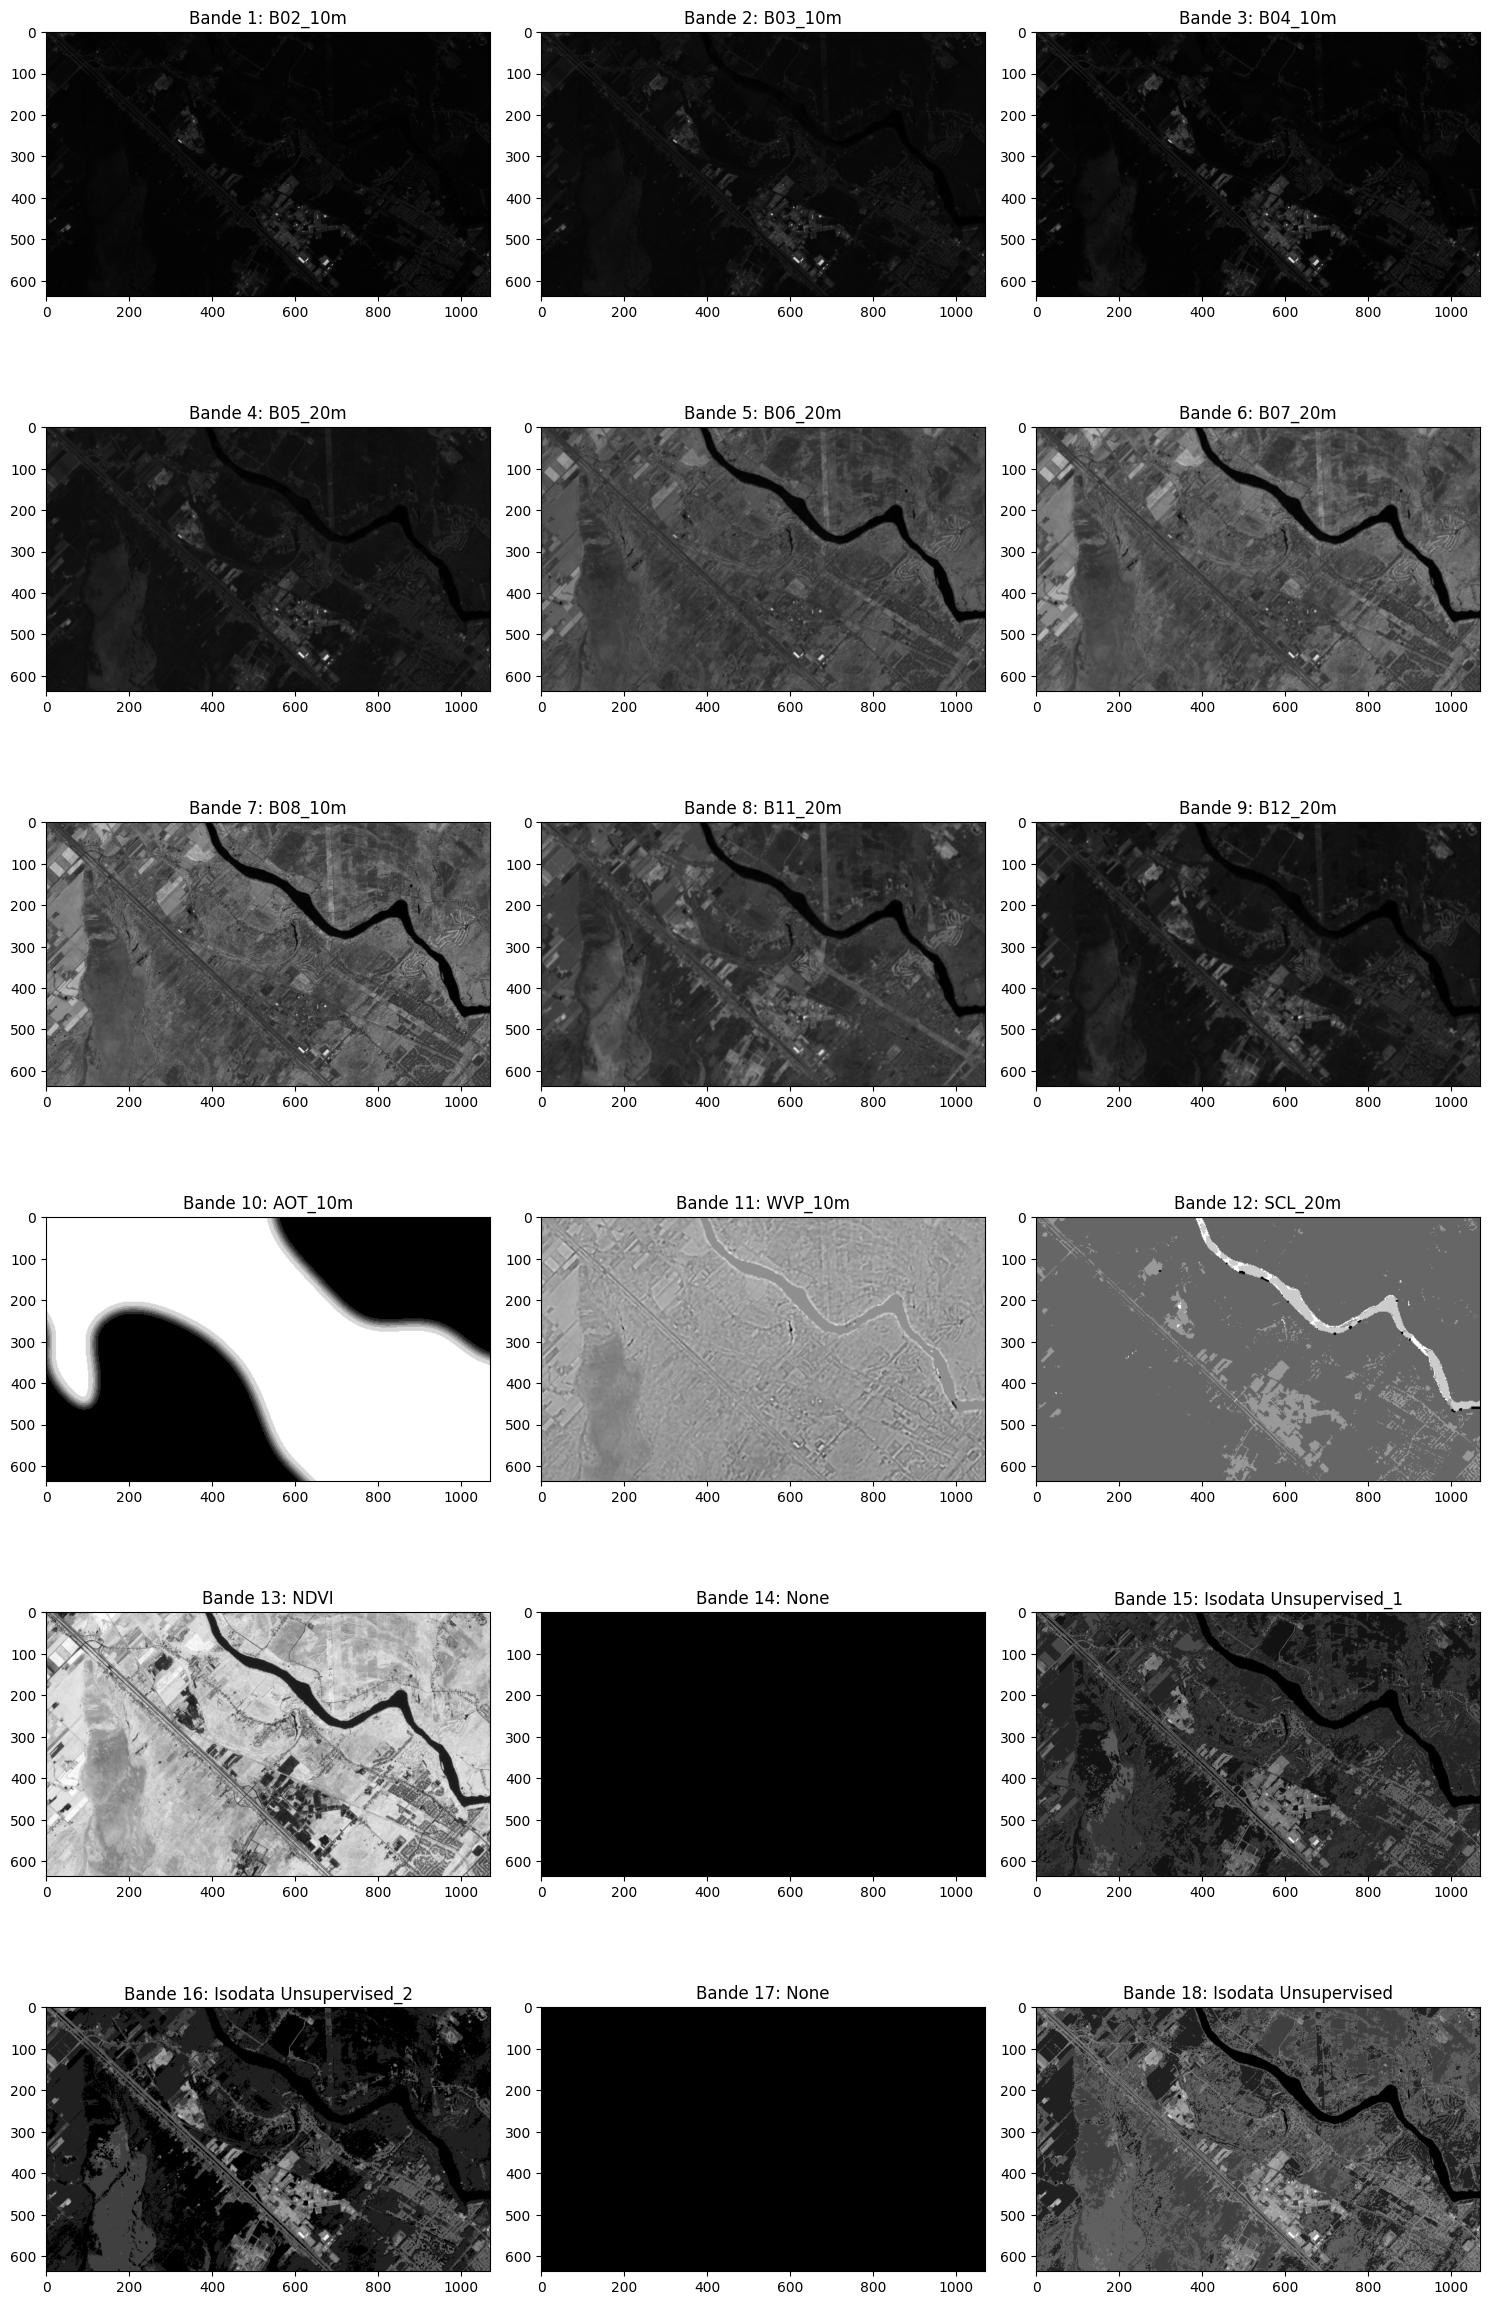

In [3]:
# Cellule 3: Visualisation rapide de toutes les bandes
def plot_all_bands():
    num_bands = src.count
    # Calculer le nombre de lignes et colonnes pour le subplot
    n_cols = min(3, num_bands)
    n_rows = (num_bands + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < num_bands:
            band = src.read(i+1)
            show(band, ax=ax, cmap='gray')
            ax.set_title(f"Bande {i+1}: {src.descriptions[i] if src.descriptions else ''}")
        else:
            ax.axis('off')  # Masquer les subplots vides
    
    plt.tight_layout()
    plt.show()

plot_all_bands()

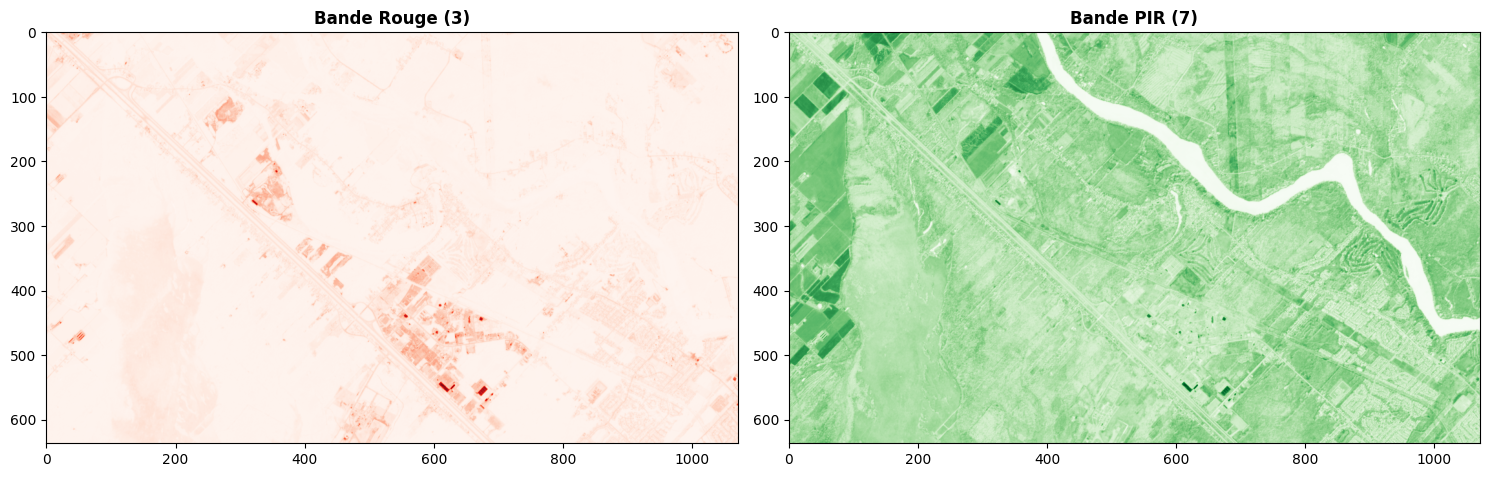

Bandes sélectionnées pour le calcul du NDVI:
  Bande rouge: 3
  Bande PIR: 7


In [7]:
# Cellule 4: Sélection manuelle des bandes pour le NDVI
# Modifiez ces valeurs après avoir examiné les bandes disponibles
red_index = 3  # Exemple: Bande rouge (B04 pour Sentinel-2)
nir_index = 7  # Exemple: Bande PIR (B08 pour Sentinel-2)

# Visualiser les bandes sélectionnées
red_band = src.read(red_index)
nir_band = src.read(nir_index)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
show(red_band, ax=ax1, cmap='Reds', title=f"Bande Rouge ({red_index})")
show(nir_band, ax=ax2, cmap='Greens', title=f"Bande PIR ({nir_index})")
plt.tight_layout()
plt.show()

print(f"Bandes sélectionnées pour le calcul du NDVI:")
print(f"  Bande rouge: {red_index}")
print(f"  Bande PIR: {nir_index}")

In [8]:
# Cellule 5: Fonctions utilitaires pour le traitement
def load_band(image_path, band_index):
    """Charge une bande spécifique de l'image"""
    with rasterio.open(image_path) as src:
        band = src.read(band_index)
        profile = src.profile.copy()
    return band, profile

def save_raster(data, profile, output_path, dtype=None):
    """Sauvegarde un raster au format GeoTIFF"""
    if dtype:
        profile.update(count=1, dtype=dtype, compress='lzw')
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)
    print(f"Fichier sauvegardé: {output_path}")

Utilisation de la bande 3 pour le rouge et de la bande 7 pour le PIR
Chargement des bandes...
Dimensions des bandes: (637, 1071)
Calcul du NDVI...
Fichier sauvegardé: D:\UQTR\Hiver 2025\Télédétection\TP3\resultats\ndvi_32bit.tif
Étirement du NDVI...
Fichier sauvegardé: D:\UQTR\Hiver 2025\Télédétection\TP3\resultats\ndvi_8bit.tif


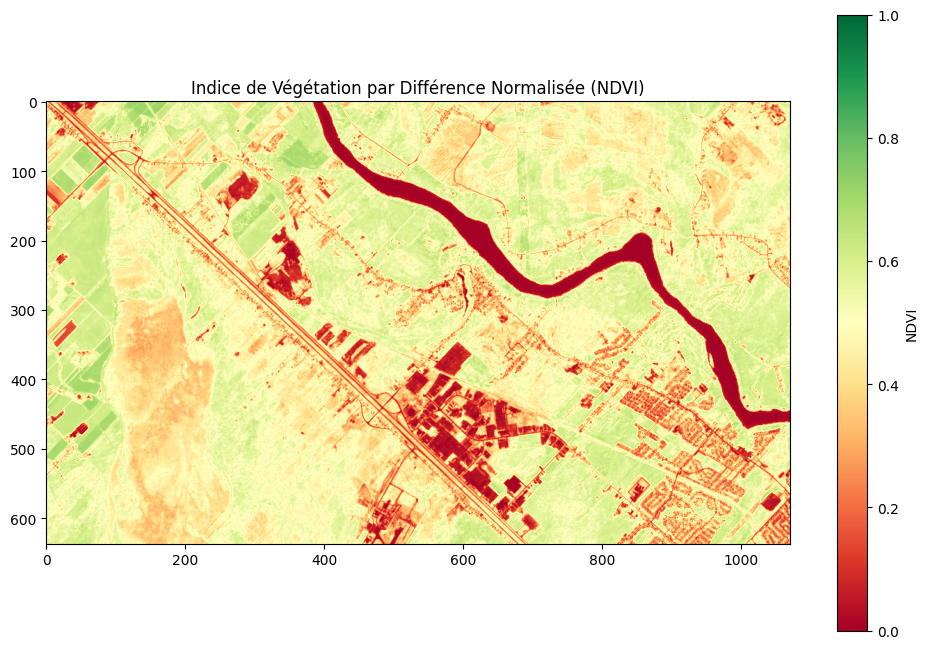

In [9]:
# Cellule 6: Calcul du NDVI
# Définir le répertoire de sortie
output_dir = os.path.join(os.path.dirname(input_file), "resultats")
os.makedirs(output_dir, exist_ok=True)

print(f"Utilisation de la bande {red_index} pour le rouge et de la bande {nir_index} pour le PIR")

# Charger les bandes
print("Chargement des bandes...")
red_band, profile = load_band(input_file, red_index)
nir_band, _ = load_band(input_file, nir_index)

print(f"Dimensions des bandes: {red_band.shape}")

# Calculer le NDVI
print("Calcul du NDVI...")
# Convertir en float32
red = red_band.astype(np.float32)
nir = nir_band.astype(np.float32)

# Formule NDVI = (PIR - R) / (PIR + R)
denominator = nir + red
ndvi = np.zeros_like(red, dtype=np.float32)
valid_mask = denominator > 0
ndvi[valid_mask] = (nir[valid_mask] - red[valid_mask]) / denominator[valid_mask]

# Ramener les valeurs négatives à 0 (optionnel)
ndvi[ndvi < 0] = 0

# Sauvegarder le NDVI (32bit)
ndvi_32bit_path = os.path.join(output_dir, "ndvi_32bit.tif")
save_raster(ndvi, profile, ndvi_32bit_path, dtype=rasterio.float32)

# Étirement linéaire du NDVI (8bit)
print("Étirement du NDVI...")
ndvi_min = np.min(ndvi)
ndvi_max = np.max(ndvi)
ndvi_8bit = ((ndvi - ndvi_min) / (ndvi_max - ndvi_min) * 255).astype(np.uint8)

# Sauvegarder le NDVI 8bit
ndvi_8bit_path = os.path.join(output_dir, "ndvi_8bit.tif")
save_raster(ndvi_8bit, profile, ndvi_8bit_path, dtype=rasterio.uint8)

# Visualiser le NDVI
plt.figure(figsize=(12, 8))
plt.imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar(label='NDVI')
plt.title("Indice de Végétation par Différence Normalisée (NDVI)")
plt.show()

In [13]:
# Cellule 7: Classification non-supervisée (IsoData/KMeans)
# Nombre de clusters pour la classification KMeans
n_clusters = 10  # Modifiez cette valeur si nécessaire

print("Classification non-supervisée...")

# Créer un stack de bandes pour la classification (rouge, PIR, NDVI)
stack = np.stack([red_band, nir_band, ndvi])

# Reformater pour KMeans
n_bands, height, width = stack.shape
data_for_clustering = stack.reshape(n_bands, -1).T

# Filtrer les valeurs nulles
valid_pixels = ~np.isnan(data_for_clustering).any(axis=1)
valid_data = data_for_clustering[valid_pixels]

# Appliquer KMeans (équivalent à IsoData)
print(f"Exécution de la classification K-means avec {n_clusters} classes...")
kmeans = KMeans(
    n_clusters=n_clusters, 
    max_iter=30,
    init='k-means++',
    random_state=42,
    n_init='auto'
)

# Classification
clusters = kmeans.fit_predict(valid_data)

# Reconstruire l'image classifiée
classification = np.zeros(valid_pixels.shape[0], dtype=np.uint8)
classification[valid_pixels] = clusters + 1  # Classes commencent à 1
classification = classification.reshape(height, width)

# Sauvegarder la classification
class_path = os.path.join(output_dir, "classification_non_supervisee.tif")
save_raster(classification, profile, class_path, dtype=rasterio.uint8)

# Créer des classes NDVI
print("Création des classes NDVI...")
ndvi_classes = np.zeros_like(ndvi, dtype=np.uint8)

# Appliquer les seuils
ndvi_classes[(ndvi >= 0) & (ndvi <= 0.5)] = 2
ndvi_classes[(ndvi > 0.5) & (ndvi <= 1.0)] = 3

# Sauvegarder les classes NDVI
classes_path = os.path.join(output_dir, "ndvi_classes.tif")
save_raster(ndvi_classes, profile, classes_path, dtype=rasterio.uint8)

Classification non-supervisée...
Exécution de la classification K-means avec 10 classes...
Fichier sauvegardé: D:\UQTR\Hiver 2025\Télédétection\TP3\resultats\classification_non_supervisee.tif
Création des classes NDVI...
Fichier sauvegardé: D:\UQTR\Hiver 2025\Télédétection\TP3\resultats\ndvi_classes.tif


C:\Users\thier\AppData\Local\Temp\ipykernel_2508\3835971496.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ndvi = plt.cm.get_cmap('viridis', 4)  # 4 classes (0, 1, 2, 3)
C:\Users\thier\AppData\Local\Temp\ipykernel_2508\3835971496.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_clusters = plt.cm.get_cmap('tab20', n_clusters + 1)


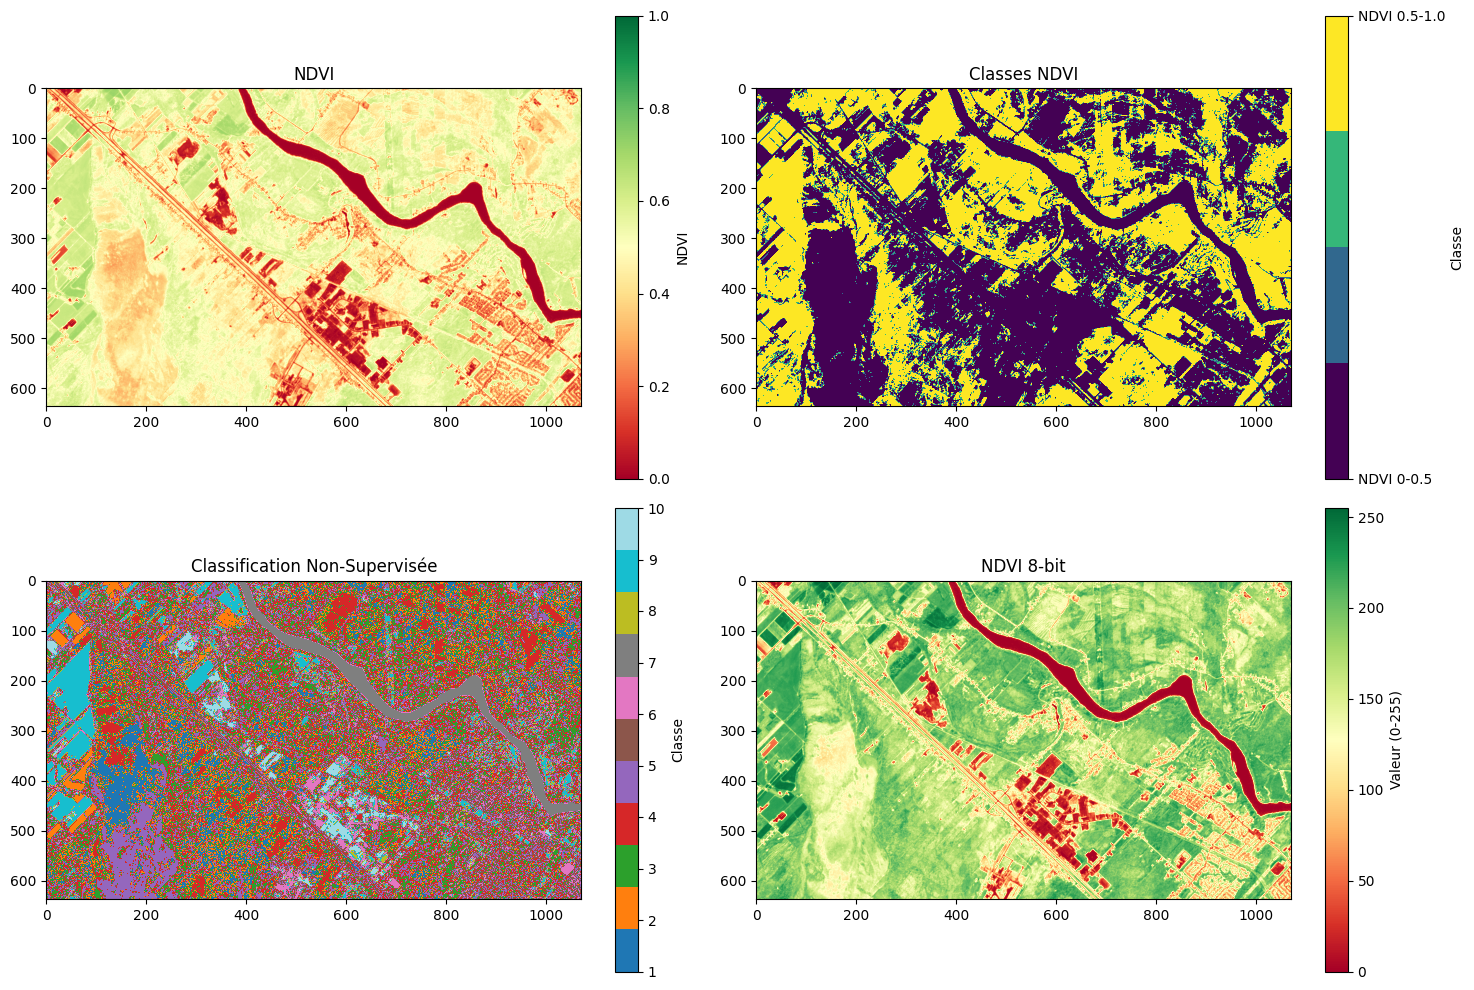


Traitement terminé avec succès!
Tous les résultats sont dans le dossier: D:\UQTR\Hiver 2025\Télédétection\TP3\resultats


In [14]:
# Cellule 8: Visualisation des résultats
plt.figure(figsize=(15, 10))

# NDVI
plt.subplot(221)
plt.title("NDVI")
plt.imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar(label='NDVI')

# NDVI classes
plt.subplot(222)
plt.title("Classes NDVI")
cmap_ndvi = plt.cm.get_cmap('viridis', 4)  # 4 classes (0, 1, 2, 3)
img = plt.imshow(ndvi_classes, cmap=cmap_ndvi)
cbar = plt.colorbar(img, ticks=[0, 1, 2, 3])
cbar.set_label('Classe')
cbar.ax.set_yticklabels(['Non-classé', 'Classe 1', 'NDVI 0-0.5', 'NDVI 0.5-1.0'])

# Classification
plt.subplot(223)
plt.title("Classification Non-Supervisée")
cmap_clusters = plt.cm.get_cmap('tab20', n_clusters + 1)
plt.imshow(classification, cmap=cmap_clusters)
plt.colorbar(label='Classe')

# NDVI 8bit
plt.subplot(224)
plt.title("NDVI 8-bit")
plt.imshow(ndvi_8bit, cmap='RdYlGn')
plt.colorbar(label='Valeur (0-255)')

# Sauvegarder la figure
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "resultats_visuels.png"), dpi=300)
plt.show()

print("\nTraitement terminé avec succès!")
print(f"Tous les résultats sont dans le dossier: {output_dir}")

In [ ]:
# Cellule 9 (optionnel): Statistiques sur les résultats
# Statistiques NDVI
ndvi_stats = {
    "Min": np.min(ndvi),
    "Max": np.max(ndvi),
    "Moyenne": np.mean(ndvi),
    "Médiane": np.median(ndvi),
    "Écart-type": np.std(ndvi)
}

# Histogramme NDVI
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Histogramme NDVI")
plt.hist(ndvi.flatten(), bins=50, color='green', alpha=0.7)
plt.xlabel("Valeur NDVI")
plt.ylabel("Fréquence")

# Statistiques sur les classes NDVI
plt.subplot(132)
plt.title("Répartition des classes NDVI")
classes, counts = np.unique(ndvi_classes, return_counts=True)
labels = ['Non-classé', 'Classe 1', 'NDVI 0-0.5', 'NDVI 0.5-1.0']
plt.bar([labels[c] for c in classes], counts, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Nombre de pixels")

# Statistiques sur la classification KMeans
plt.subplot(133)
plt.title("Répartition des classes (K-means)")
classes_km, counts_km = np.unique(classification, return_counts=True)
plt.bar([f"Classe {c}" for c in classes_km], counts_km, color='orange')
plt.xticks(rotation=90)
plt.ylabel("Nombre de pixels")

plt.tight_layout()
plt.show()

# Afficher les statistiques NDVI
print("Statistiques NDVI:")
for key, value in ndvi_stats.items():
    print(f"  {key}: {value:.4f}")

# Calculer la surface pour chaque classe (si l'information est disponible)
if hasattr(src, 'res'):
    pixel_area = src.res[0] * src.res[1]  # en unités de carte
    print(f"\nTaille de pixel: {src.res[0]} x {src.res[1]} unités")
    print(f"Surface d'un pixel: {pixel_area} unités²")
    
    print("\nSurface approximative par classe NDVI:")
    for c, count in zip(classes, counts):
        area = count * pixel_area
        print(f"  {labels[c]}: {area:.2f} unités² ({(count/ndvi.size)*100:.2f}% de l'image)")